In [1]:
import os
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm


In [2]:
class LinModel(nn.Module):
    def __init__(self):
        super(LinModel, self).__init__()
        self.lin1 = nn.Linear(1024*7*7, 4068)
        self.lin2 = nn.Linear(4068, 512)
        self.lin3 = nn.Linear(512, 8)

    def forward(self, x):
        x = self.lin1(x)
        x = self.lin2(x)
        x = self.lin3(x)
        return x

In [3]:
# lane_model = torch.load('saved_models/vgg16_pretained_2lane.pth',map_location='cuda:0')
# box_model = torch.load('saved_models/unet_pretrained_boxnet.pth',map_location='cuda:0')
lane_model = torch.load('saved_models/unet_plain_exp_3.pth',map_location='cuda:0')

/home/anudeep/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'models.Unet.UNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [4]:
data_dir = '/home/anudeep/lane-detection/dataset'
data = pd.read_json(os.path.join(data_dir, 'label_data.json'), lines=True)
data.info()
print(len(data.raw_file))
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2855 entries, 0 to 2854
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   lanes      2855 non-null   object
 1   h_samples  2855 non-null   object
 2   raw_file   2855 non-null   object
dtypes: object(3)
memory usage: 67.0+ KB
2855


,lanes,h_samples,raw_file
0,"[[-100, -100, -100, -100, 632, 625, 617, 609, ...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/6040/20.jpg
1,"[[-100, -100, -100, 658, 646, 635, 623, 612, 6...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/5320/20.jpg
2,"[[-100, 570, 554, 538, 522, 505, 489, 473, 456...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/23700/20.jpg
3,"[[-100, -100, -100, -100, 555, 542, 530, 517, ...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/51660/20.jpg
4,"[[-100, -100, -100, 522, 525, 528, 531, 534, 5...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/25680/20.jpg
...,...,...,...
2850,"[[-100, -100, -100, 595, 589, 583, 577, 571, 5...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-2/26520/20.jpg
2851,"[[-100, -100, 728, 683, 651, 624, 608, 592, 57...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-2/30960/20.jpg
2852,"[[417, 435, 453, 471, 477, 478, 480, 481, 482,...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-2/23220/20.jpg
2853,"[[-100, -100, -100, -100, 440, 451, 458, 458, ...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-2/35300/20.jpg


Reading from:  /home/anudeep/lane-detection/dataset/clips/0313-1/52260/20.jpg


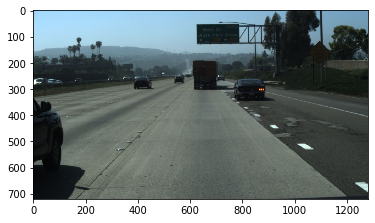

In [5]:
i=71
img_path = data.raw_file[i]
img_path = os.path.join(data_dir,img_path)
print('Reading from: ', img_path)
img_raw = cv2.imread(img_path)
img1 = cv2.cvtColor(img_raw,cv2.COLOR_BGR2RGB)
plt.imshow(img1)

In [6]:
# lane_model = lane_model.eval()

In [7]:
lane_model

UNet(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv2): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [29]:
img2 = cv2.imread('test_images/test2.jpg') 
img2 = cv2.cvtColor(img_raw,cv2.COLOR_BGR2RGB)
img = cv2.resize(img2,(128,128), cv2.INTER_NEAREST)
img = np.transpose(img, (2, 0, 1))
img = np.expand_dims(img, axis=0)

In [30]:
pred = lane_model(torch.tensor(img).float().cuda())

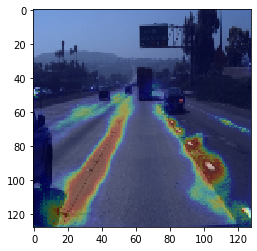

In [32]:
prediction = F.sigmoid(pred)
prediction = prediction.cpu().detach()
prediction = torch.squeeze(prediction)
plt.imshow(np.transpose(np.squeeze(img), (1, 2, 0)))
plt.imshow(prediction, cmap='jet', alpha=0.3)

In [13]:
p = prediction.numpy()
p = p*255
p = np.array(p, dtype= np.uint8)

In [14]:
ret, otsu = cv2.threshold(p,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

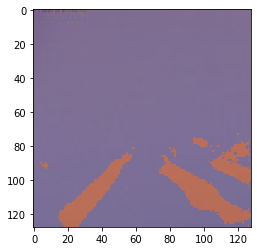

In [16]:
plt.imshow(img_raw)
plt.imshow(otsu, cmap='jet', alpha=0.5)